In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from dateutil.relativedelta import relativedelta
import sys, copy, os, shutil
from tqdm.notebook import tqdm

# load in our true case counts
cases = pd.read_csv("processed/weekly_cases.csv")
cases.date = pd.to_datetime(cases.date)
cases.set_index("date", inplace=True)

# our set of locations
locations = pd.read_csv("processed/locations.csv")

# color-blind friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# let's use a common test set for all horizons just to keep things fair and comparable
pred_start_shared = pd.Timestamp(2021, 2, 21)
pred_end = cases.index[-1]

# load in our logs
logs = pd.read_csv("performance_logs.csv", low_memory=False)

# columns of interest for scaled metrics
sMAE_cols = [f"sMAE_{loc}" for loc in locations.location_key.values]

# RQ1: How do the best temporal GNN variants compare against the best autoregressive, vector autoregressive, and persistence baselines? Specifically, how does this performance change as we increase the forecast horizon?

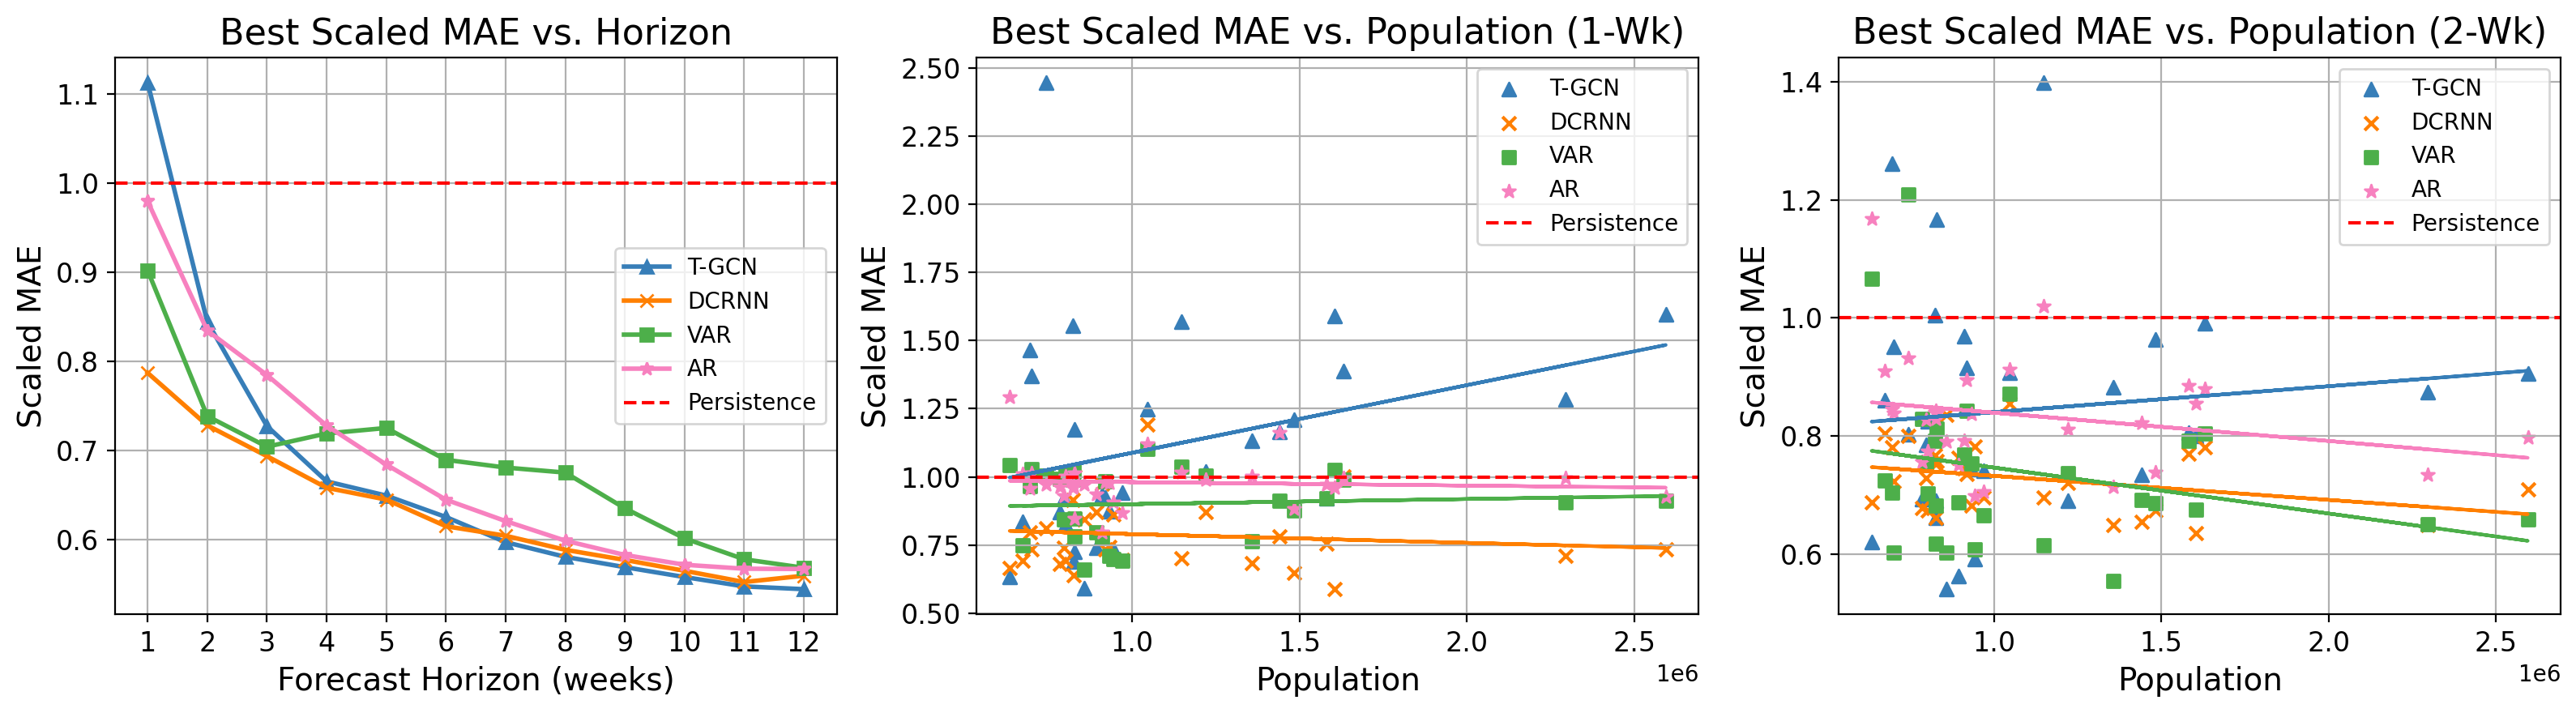

In [2]:
# best DCRNN vs. T-GCN vs. VAR vs. AR
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4.5))

# get our population values
pop_values = locations.set_index("location_key").population.values

###########

# plot best sMAE values for each horizon, starting with T-GCN
tgcn_vals = logs.query("model == 'tgcn'")\
.sort_values(by="sMAE_tot").groupby("fh").first().reset_index()
ax[0].plot(np.arange(1, 12+1), tgcn_vals.sMAE_tot, color=colors[0], marker="^", linewidth=2, label="T-GCN")

# next, show DCRNN
dcrnn_vals = logs.query("model == 'dcrnn'")\
.sort_values(by="sMAE_tot").groupby("fh").first().reset_index()
ax[0].plot(np.arange(1, 12+1), dcrnn_vals.sMAE_tot, color=colors[1], marker="x", linewidth=2, label="DCRNN")

# next, show VAR
var_vals = logs.query("model == 'linear' and cluster_mech != 3")\
.sort_values(by="sMAE_tot").groupby("fh").first().reset_index()
ax[0].plot(np.arange(1, 12+1), var_vals.sMAE_tot, color=colors[2], marker="s", linewidth=2, label="VAR")

# finally show standard AR
ar_vals = logs.query("model == 'linear' and cluster_mech == 3")\
.sort_values(by="sMAE_tot").groupby("fh").first().reset_index()
ax[0].plot(np.arange(1, 12+1), ar_vals.sMAE_tot, color=colors[3], marker="*", linewidth=2, label="AR")

# beautify
ax[0].grid()
ax[0].set_xticks(np.arange(1, 12+1))
ax[0].tick_params(labelsize=12)
ax[0].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[0].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[0].set_ylabel("Scaled MAE", fontsize=14)
ax[0].set_title("Best Scaled MAE vs. Horizon", fontsize=16)
ax[0].legend()

###########

# plot for 1-week ahead, residuals as a function of county + population, starting with T-GCN
tgcn_vals = logs.query("fh == 1 and model == 'tgcn'").sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[1].scatter(pop_values, tgcn_vals.values, 
              color=colors[0], marker="^", label="T-GCN")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, tgcn_vals, 1)
lobf = np.poly1d(coefs)
ax[1].plot(pop_values, lobf(pop_values), color=colors[0])

# move to 1-week ahead with DCRNN
dcrnn_vals = logs.query("fh == 1 and model == 'dcrnn'").sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[1].scatter(pop_values, dcrnn_vals.values, 
              color=colors[1], marker="x", label="DCRNN")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, dcrnn_vals, 1)
lobf = np.poly1d(coefs)
ax[1].plot(pop_values, lobf(pop_values), color=colors[1])

# now, do 1-week ahead with VAR
var_vals = logs.query("fh == 1 and model == 'linear' and cluster_mech != 3")\
.sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[1].scatter(pop_values, var_vals.values, 
              color=colors[2], marker="s", label="VAR")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, var_vals, 1)
lobf = np.poly1d(coefs)
ax[1].plot(pop_values, lobf(pop_values), color=colors[2])

# now, do 1-week ahead with AR
ar_vals = logs.query("fh == 1 and model == 'linear' and cluster_mech == 3")\
.sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[1].scatter(pop_values, ar_vals.values, 
              color=colors[3], marker="*", label="AR")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, ar_vals, 1)
lobf = np.poly1d(coefs)
ax[1].plot(pop_values, lobf(pop_values), color=colors[3])

# beautify
ax[1].grid()
ax[1].tick_params(labelsize=12)
ax[1].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[1].set_xlabel("Population", fontsize=14)
ax[1].set_ylabel("Scaled MAE", fontsize=14)
ax[1].set_title("Best Scaled MAE vs. Population (1-Wk)", fontsize=16)
ax[1].legend()

###########

# plot for 2-week ahead, residuals as a function of county + population, starting with T-GCN
tgcn_vals = logs.query("fh == 2 and model == 'tgcn'").sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[2].scatter(pop_values, tgcn_vals.values, 
              color=colors[0], marker="^", label="T-GCN")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, tgcn_vals, 1)
lobf = np.poly1d(coefs)
ax[2].plot(pop_values, lobf(pop_values), color=colors[0])

# move to 2-week ahead with DCRNN
dcrnn_vals = logs.query("fh == 2 and model == 'dcrnn'").sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[2].scatter(pop_values, dcrnn_vals.values, 
              color=colors[1], marker="x", label="DCRNN")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, dcrnn_vals, 1)
lobf = np.poly1d(coefs)
ax[2].plot(pop_values, lobf(pop_values), color=colors[1])

# now, do 2-week ahead with VAR
var_vals = logs.query("fh == 2 and model == 'linear' and cluster_mech != 3")\
.sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[2].scatter(pop_values, var_vals.values, 
              color=colors[2], marker="s", label="VAR")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, var_vals, 1)
lobf = np.poly1d(coefs)
ax[2].plot(pop_values, lobf(pop_values), color=colors[2])

# now, do 2-week ahead with AR
ar_vals = logs.query("fh == 2 and model == 'linear' and cluster_mech == 3")\
.sort_values(by="sMAE_tot")[sMAE_cols].iloc[0]
ax[2].scatter(pop_values, ar_vals.values, 
              color=colors[3], marker="*", label="AR")

# plot lines of best fit
coefs = np.polyfit(locations.set_index("location_key").population.values, ar_vals, 1)
lobf = np.poly1d(coefs)
ax[2].plot(pop_values, lobf(pop_values), color=colors[3])

# beautify
ax[2].grid()
ax[2].tick_params(labelsize=12)
ax[2].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[2].set_xlabel("Population", fontsize=14)
ax[2].set_ylabel("Scaled MAE", fontsize=14)
ax[2].set_title("Best Scaled MAE vs. Population (2-Wk)", fontsize=16)
ax[2].legend()

# beautify at the very end
plt.savefig("figures/rq1_overall+1+2.png", facecolor="white", bbox_inches="tight")
plt.tight_layout()
plt.show()

# RQ2: Within temporal GNNs, how does the choice of apriori edge connections affect forecasting performance over increasing horizon?

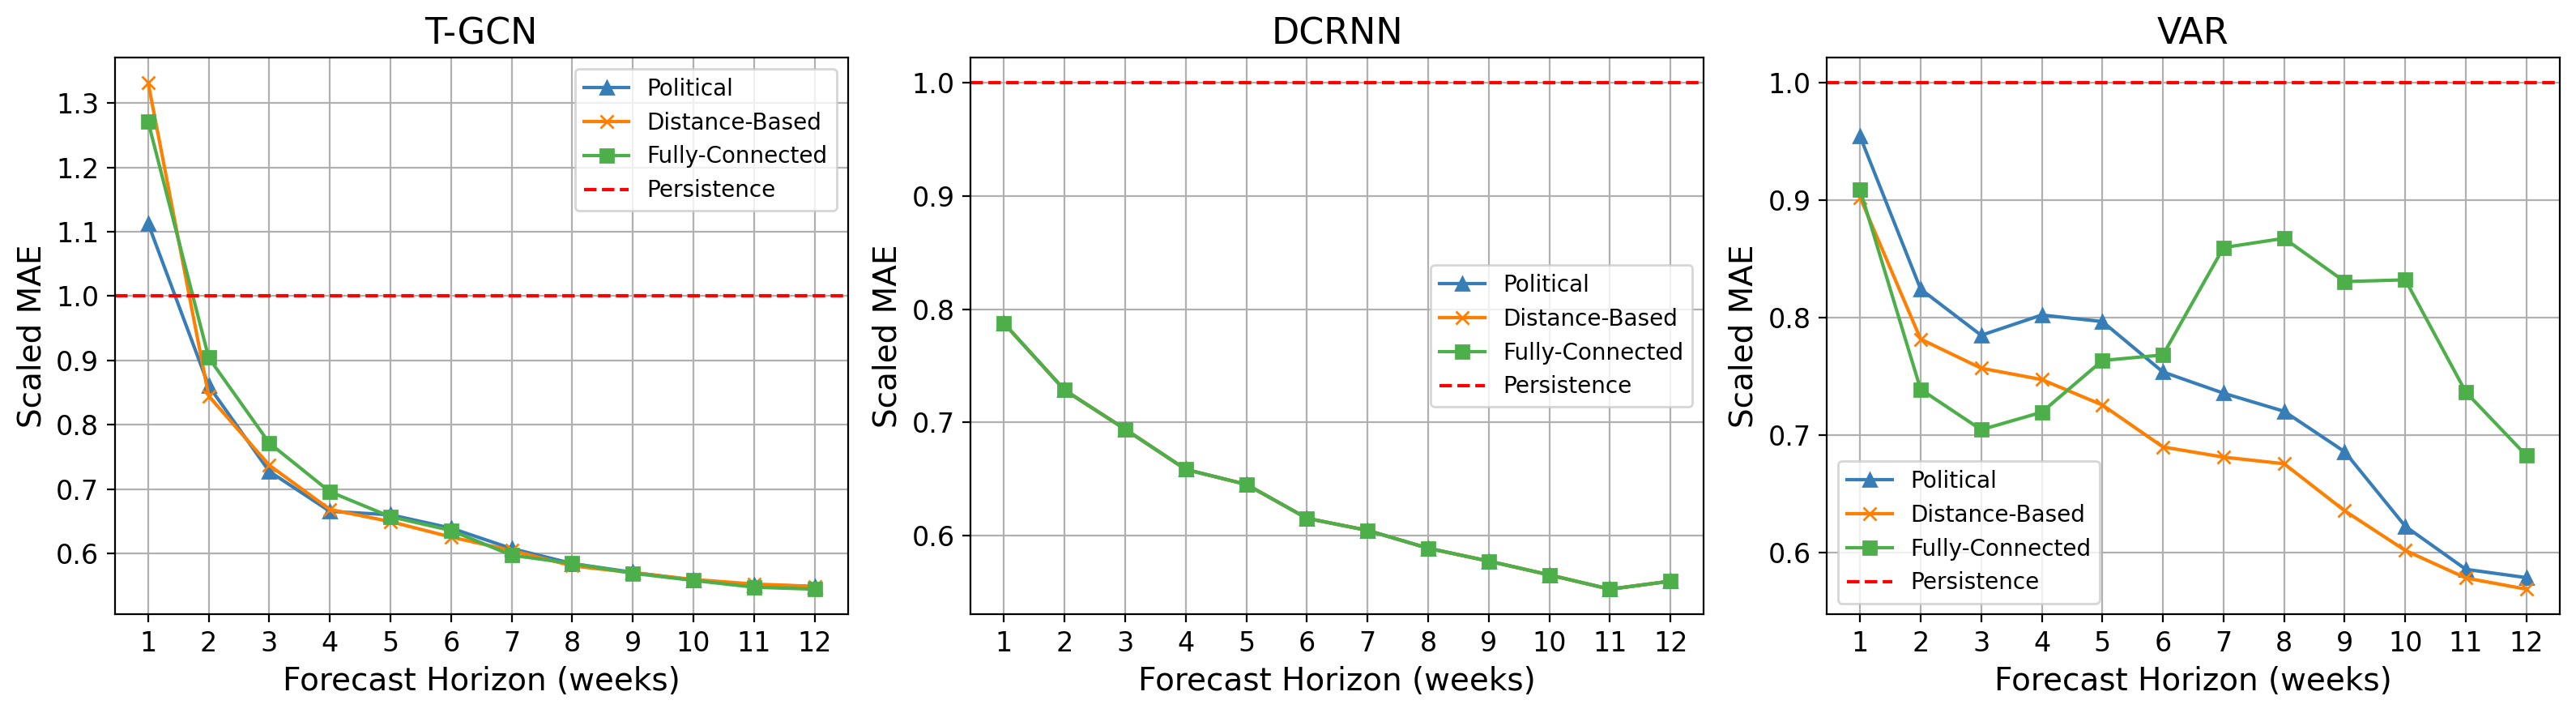

In [3]:
# let's plot the 3-4 different edge connections' best performers on each model
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4.5))


###### T-GCN errors vs. edge connection curves

# start with T-GCN - political
tgcn_vals = logs.query("model == 'tgcn' and cluster_mech == 0")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[0].plot(tgcn_vals, marker="^", color=colors[0], label="Political")

# next, work with T-GCN - distance-based
tgcn_vals = logs.query("model == 'tgcn' and cluster_mech == 1")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[0].plot(tgcn_vals, marker="x",color=colors[1], label="Distance-Based")

# next, work with T-GCN - fully-connected
tgcn_vals = logs.query("model == 'tgcn' and cluster_mech == 2")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[0].plot(tgcn_vals, marker="s",color=colors[2], label="Fully-Connected")

# beautify
ax[0].grid()
ax[0].set_xticks(np.arange(1, 12+1))
ax[0].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[0].set_ylabel("Scaled MAE", fontsize=14)
ax[0].set_title("T-GCN", fontsize=16)
ax[0].tick_params(labelsize=12)
ax[0].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[0].legend()

###### DCRNN errors vs. edge connection curves

# start with DCRNN - political
dcrnn_vals = logs.query("model == 'dcrnn' and cluster_mech == 0")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[1].plot(dcrnn_vals, marker="^", color=colors[0], label="Political")

# next, work with DCRNN - distance-based
dcrnn_vals = logs.query("model == 'dcrnn' and cluster_mech == 1")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[1].plot(dcrnn_vals, marker="x",color=colors[1], label="Distance-Based")

# next, work with DCRNN - fully-connected
dcrnn_vals = logs.query("model == 'dcrnn' and cluster_mech == 2")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[1].plot(dcrnn_vals, marker="s",color=colors[2], label="Fully-Connected")

# beautify
ax[1].grid()
ax[1].set_xticks(np.arange(1, 12+1))
ax[1].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[1].set_ylabel("Scaled MAE", fontsize=14)
ax[1].set_title("DCRNN", fontsize=16)
ax[1].tick_params(labelsize=12)
ax[1].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[1].legend()

###### VAR errors vs. edge connection curves

# start with DCRNN - political
var_vals = logs.query("model == 'linear' and cluster_mech == 0")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[2].plot(var_vals, marker="^", color=colors[0], label="Political")

# next, work with DCRNN - distance-based
var_vals = logs.query("model == 'linear' and cluster_mech == 1")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[2].plot(var_vals, marker="x",color=colors[1], label="Distance-Based")

# next, work with DCRNN - fully-connected
var_vals = logs.query("model == 'linear' and cluster_mech == 2")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[2].plot(var_vals, marker="s",color=colors[2], label="Fully-Connected")

# beautify
ax[2].grid()
ax[2].set_xticks(np.arange(1, 12+1))
ax[2].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[2].set_ylabel("Scaled MAE", fontsize=14)
ax[2].set_title("VAR", fontsize=16)
ax[2].tick_params(labelsize=12)
ax[2].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[2].legend()

# final beautifying
plt.tight_layout()
plt.savefig("figures/rq2_cluster-mech.png", facecolor="white", bbox_inches="tight")
plt.show()

# RQ3: from the linear models literature, we know that log-transforming case counts helps increase predictive accuracy. To what extent is this also the case with temporal GNNs?

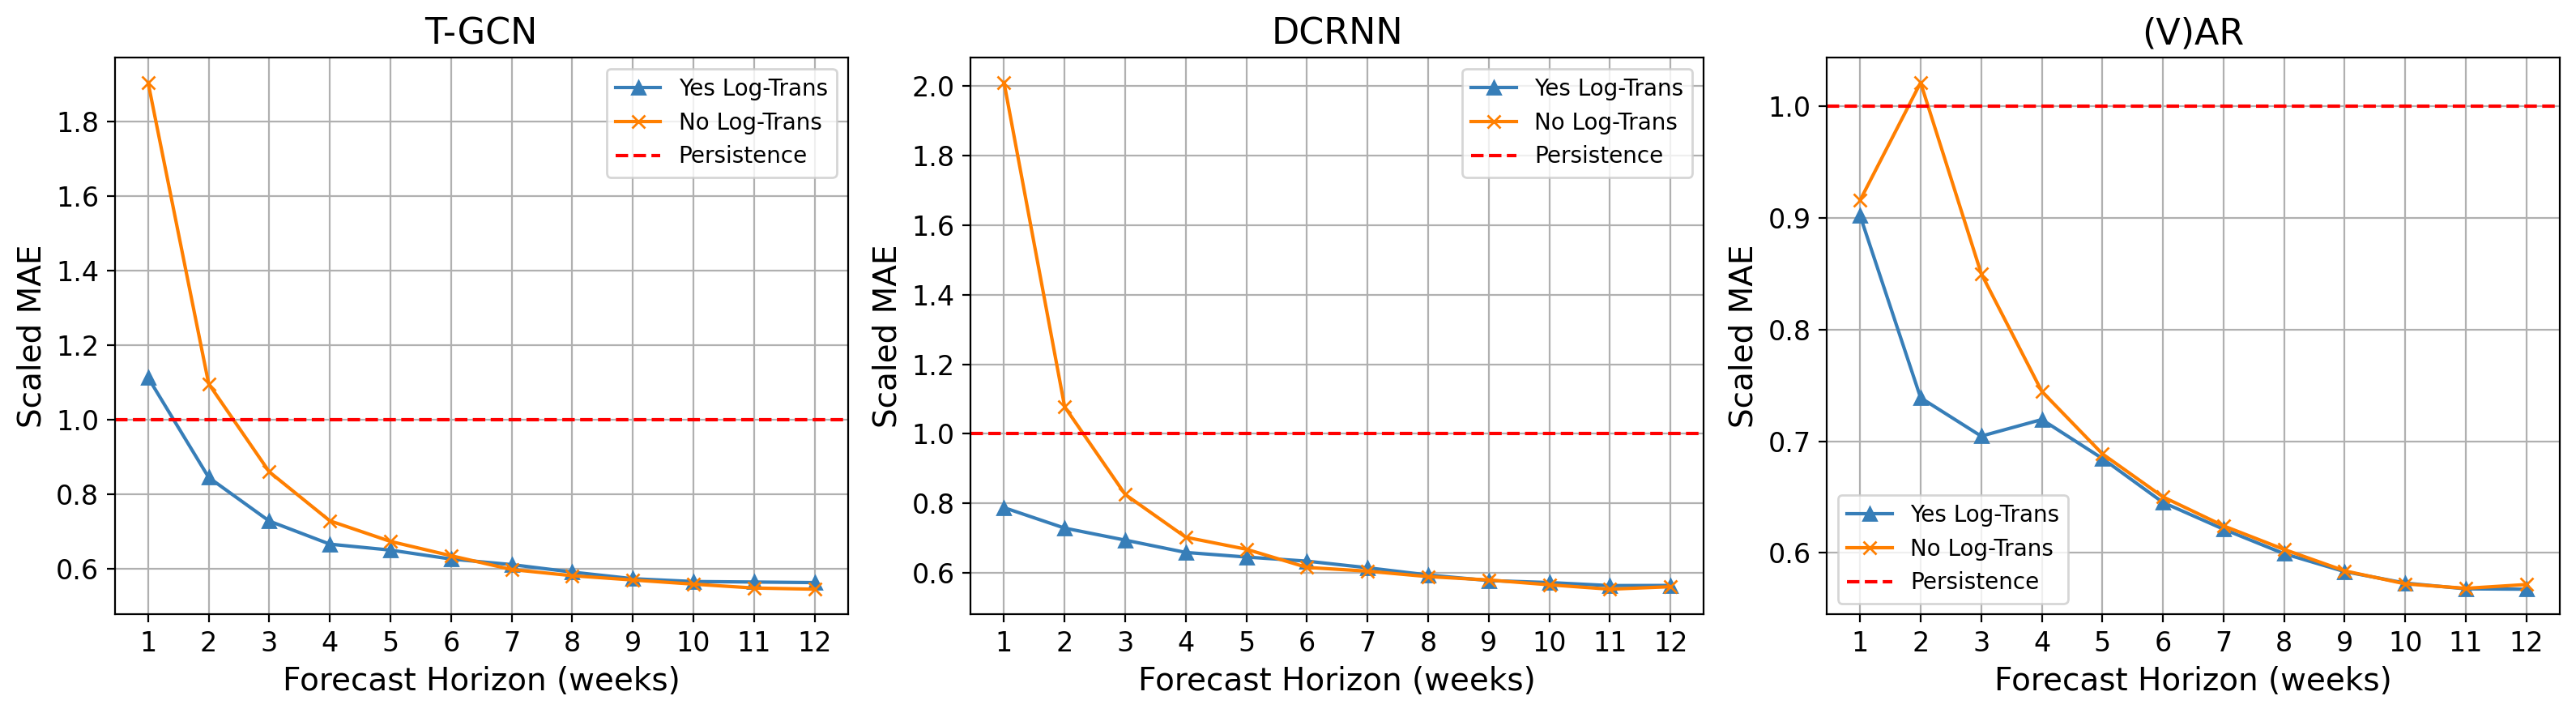

In [4]:
# let's plot yes log-transform vs. no log-transform on best models
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4.5))


###### T-GCN errors vs. log-transform

# start with T-GCN with yes-log-trans
tgcn_vals = logs.query("model == 'tgcn' and log_trans == True")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[0].plot(tgcn_vals, marker="^", color=colors[0], label="Yes Log-Trans")

# next, work with T-GCN - no-log-trans
tgcn_vals = logs.query("model == 'tgcn' and log_trans == False")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[0].plot(tgcn_vals, marker="x",color=colors[1], label="No Log-Trans")

# beautify
ax[0].grid()
ax[0].set_xticks(np.arange(1, 12+1))
ax[0].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[0].set_ylabel("Scaled MAE", fontsize=14)
ax[0].set_title("T-GCN", fontsize=16)
ax[0].tick_params(labelsize=12)
ax[0].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[0].legend()

###### DCRNN errors vs. {yes, no}-log-trans

# start with DCRNN yes log trans
dcrnn_vals = logs.query("model == 'dcrnn' and log_trans == True")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[1].plot(dcrnn_vals, marker="^", color=colors[0], label="Yes Log-Trans")

# next, work with T-GCN - no log-trans
dcrnn_vals = logs.query("model == 'dcrnn' and log_trans == False")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[1].plot(dcrnn_vals, marker="x",color=colors[1], label="No Log-Trans")

# beautify
ax[1].grid()
ax[1].set_xticks(np.arange(1, 12+1))
ax[1].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[1].set_ylabel("Scaled MAE", fontsize=14)
ax[1].set_title("DCRNN", fontsize=16)
ax[1].tick_params(labelsize=12)
ax[1].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[1].legend()

###### VAR errors vs. edge connection curves

# start with VAR yes log trans
var_vals = logs.query("model == 'linear' and log_trans == True")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[2].plot(var_vals, marker="^", color=colors[0], label="Yes Log-Trans")

# next, work with VAR - no long-trans
var_vals = logs.query("model == 'linear' and log_trans == False")\
.sort_values(by="sMAE_tot").groupby("fh").first().sMAE_tot
ax[2].plot(var_vals, marker="x",color=colors[1], label="No Log-Trans")

# beautify
ax[2].grid()
ax[2].set_xticks(np.arange(1, 12+1))
ax[2].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
ax[2].set_ylabel("Scaled MAE", fontsize=14)
ax[2].set_title("(V)AR", fontsize=16)
ax[2].tick_params(labelsize=12)
ax[2].axhline(y=1.0, color="red", linestyle="--", label="Persistence")
ax[2].legend()

# final beautifying
plt.tight_layout()
plt.savefig("figures/rq3_log-trans.png", facecolor="white", bbox_inches="tight")
plt.show()

# RQ4: how does increasing the number of lags in each set of node features affect performance? Do we just overfit or is this information indeed useful?

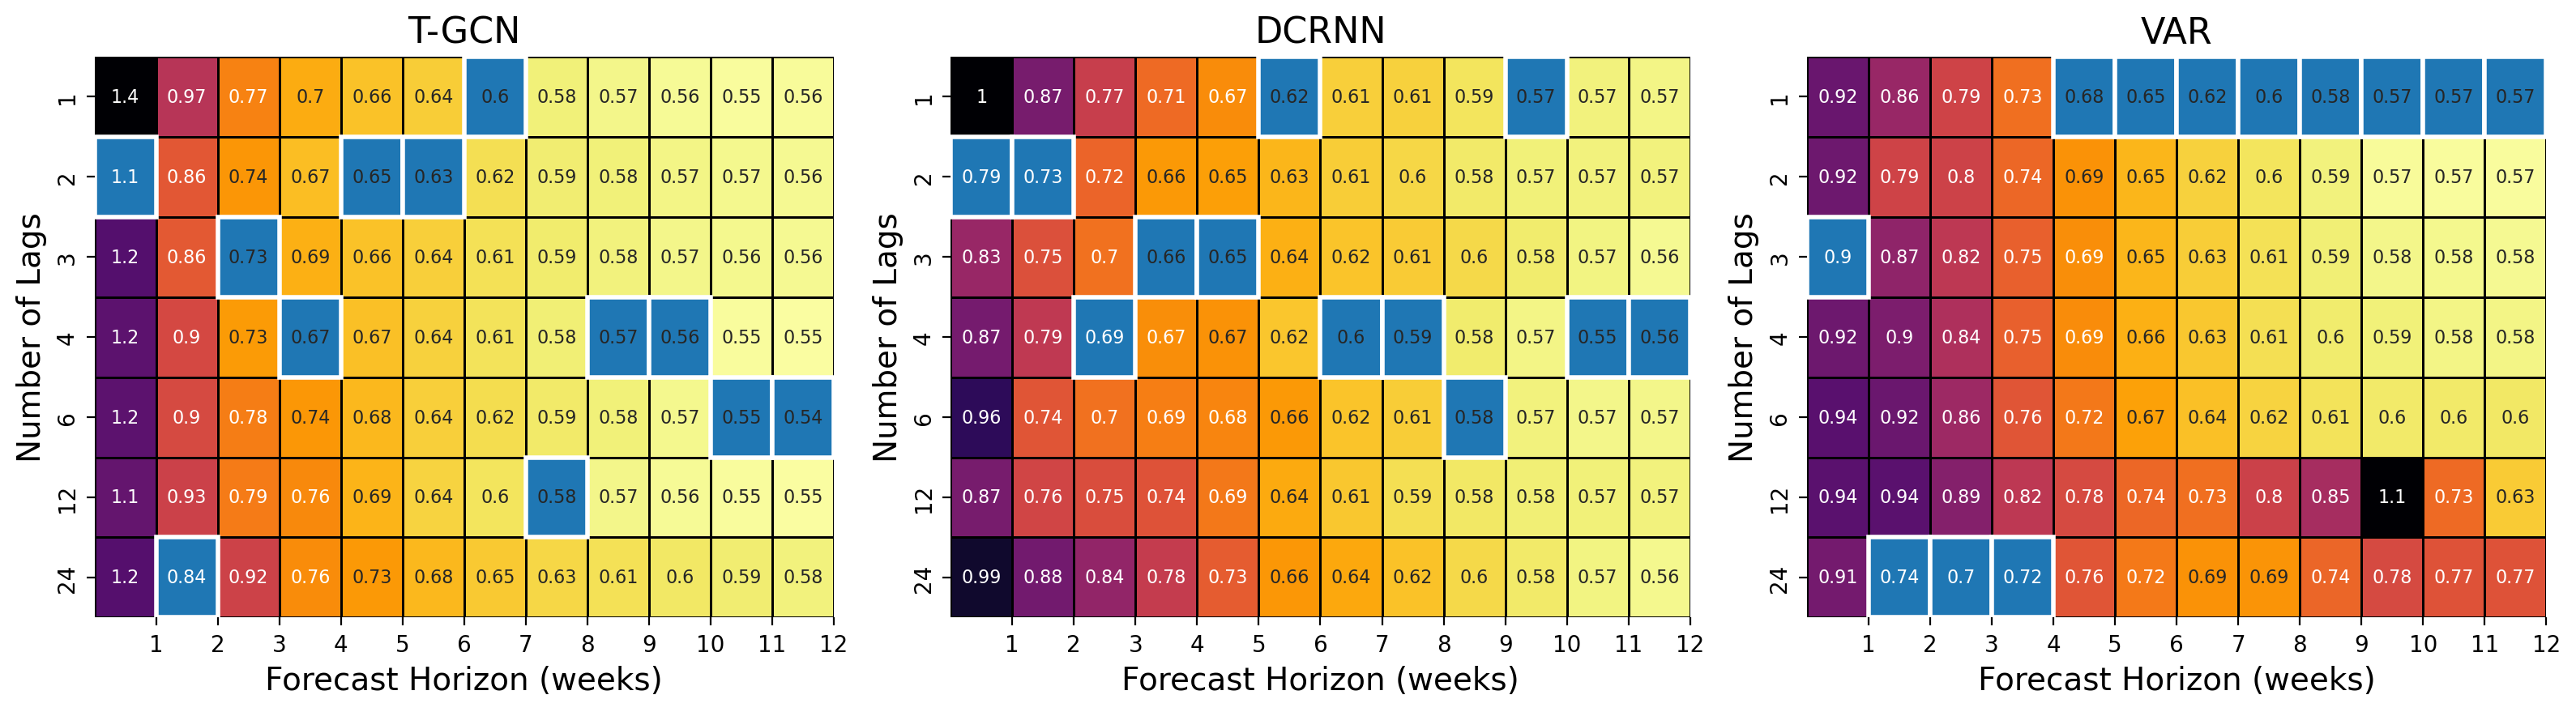

In [5]:
# let's plot yes log-transform vs. no log-transform on best models
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4.5))

# how many subplots have we filled?
idx = 0

# iterate through each of our models
for (model, model_desc) in [("tgcn", "T-GCN"), ("dcrnn", "DCRNN"), ("linear", "VAR")]:

    # create + populate a matrix to store our best sMAEs
    best_vals = np.zeros(shape=(7, 12))
    for i, num_lags in enumerate(sorted(logs.num_lags.unique())):
        for j, fh in enumerate(range(1, 12+1)):
            best_vals[i, j] = logs.query(f"model == '{model}' and fh == {fh} and num_lags == {num_lags}")\
            .sort_values(by="sMAE_tot").iloc[0].sMAE_tot
    
    # plot the colors corresponding to each error
    heatmap = sns.heatmap(-best_vals, cbar=False, cmap="inferno", 
                          annot=np.round(best_vals, 2), ax=ax[idx], 
                          annot_kws={"size" : 8}, linecolor="black", linewidths=0.5)
    
    # Find the indices of the lowest value in each column (i.e., best num_lags)
    min_idxs = np.argmin(best_vals, axis=0)
    for i, col in enumerate(min_idxs):
        heatmap.add_patch(plt.Rectangle((i, col), 1, 1, fill=True, edgecolor='white', lw=2))
        
    # labeling
    ax[idx].set_xticks(np.arange(1, 12+1)); ax[idx].set_xticklabels(np.arange(1, 12+1))
    ax[idx].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
    ax[idx].set_yticklabels(sorted(logs.num_lags.unique()))
    ax[idx].set_ylabel("Number of Lags", fontsize=14)
    ax[idx].set_title(model_desc, fontsize=16)
    
    # increment our counter
    idx += 1
    
# beautify at the very end
plt.tight_layout()
plt.savefig("figures/rq4_num-lags.png", facecolor="white", bbox_inches="tight")
plt.show()

# RQ5: how does increasing the number of neurons affect performance? Do we also just overfit or is this information useful?

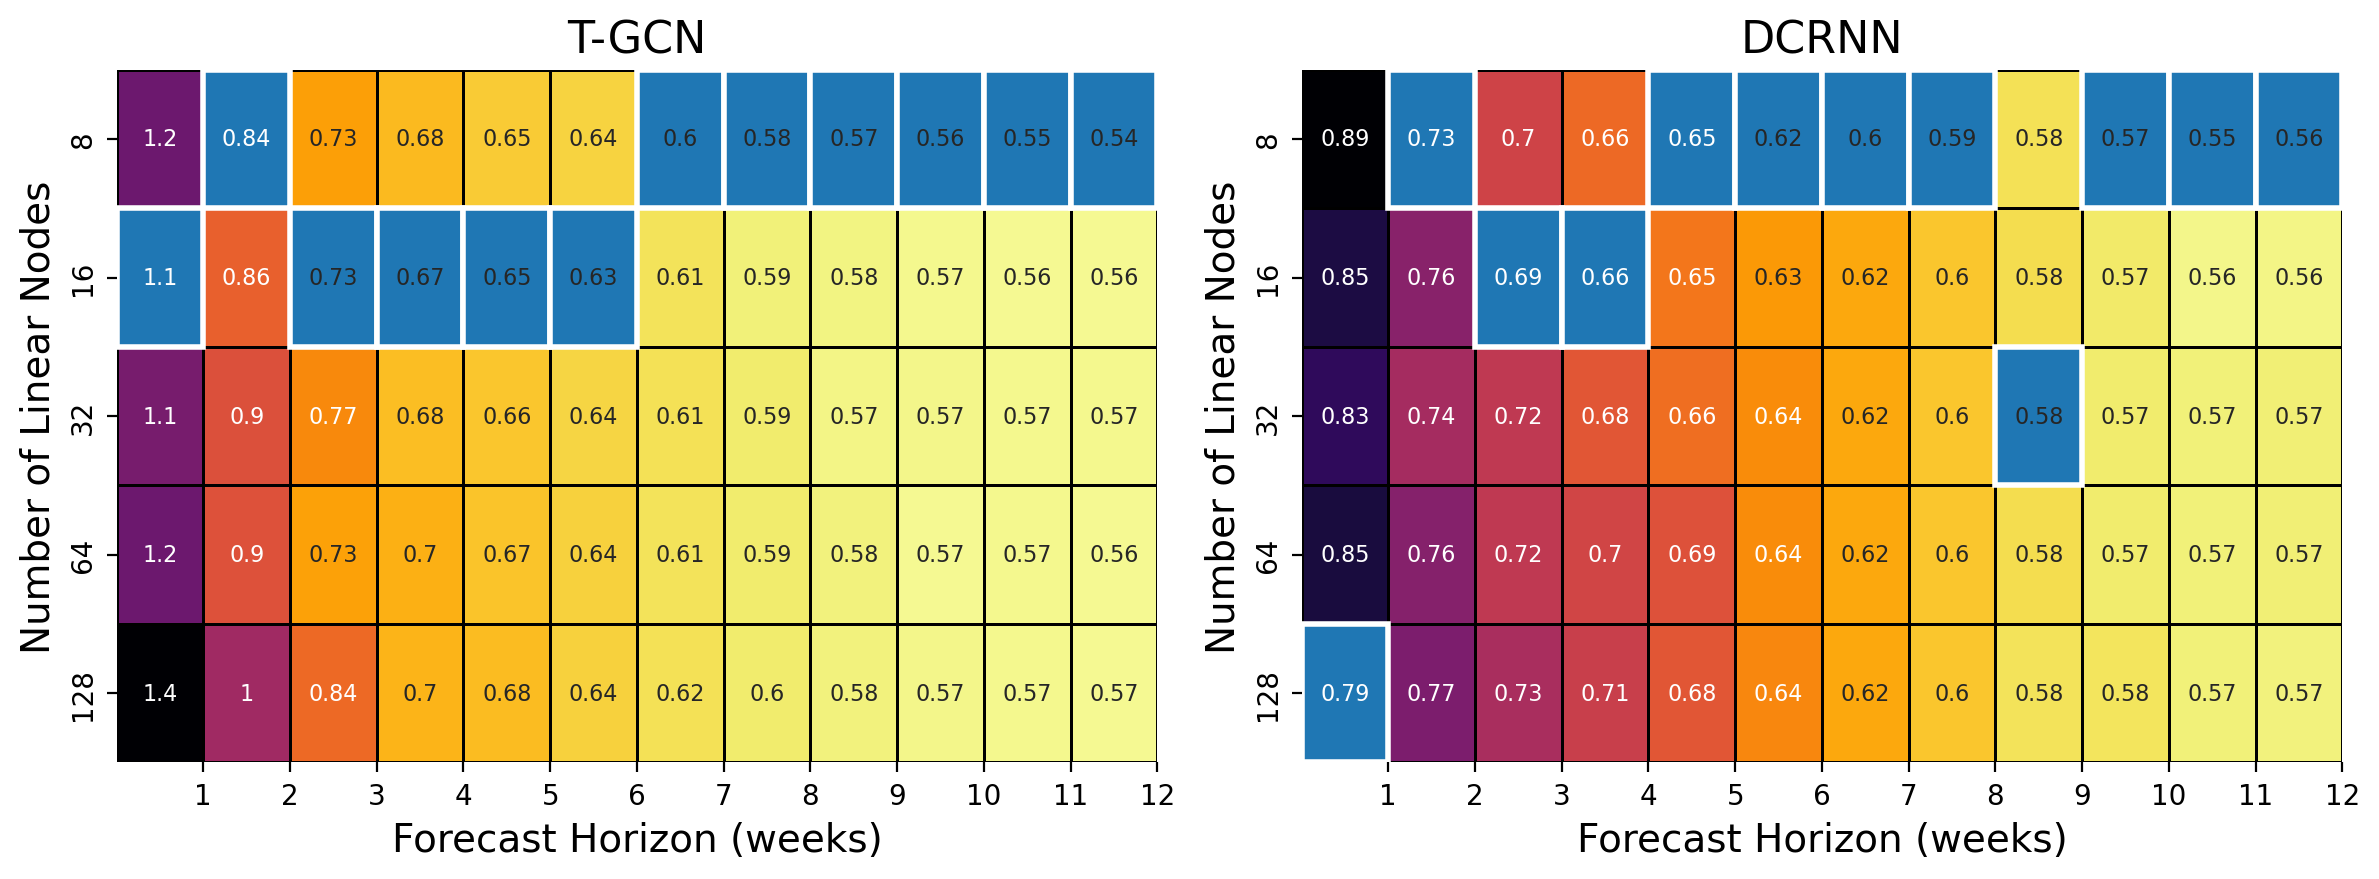

In [6]:
# what num_nodes options do we have?
num_nodes_options = sorted(logs.num_nodes.unique()[~np.isnan(logs.num_nodes.unique())].astype(int))

# let's plot yes log-transform vs. no log-transform on best models
fig, ax = plt.subplots(1, 2, dpi=200, figsize=(12, 4.5))

# how many subplots have we filled?
idx = 0

# iterate through each of our models
for (model, model_desc) in [("tgcn", "T-GCN"), ("dcrnn", "DCRNN")]:

    # create + populate a matrix to store our best sMAEs
    best_vals = np.zeros(shape=(5, 12))
    for i, num_nodes in enumerate(num_nodes_options):
        for j, fh in enumerate(range(1, 12+1)):
            best_vals[i, j] = logs.query(f"model == '{model}' and fh == {fh} and num_nodes == {num_nodes}")\
            .sort_values(by="sMAE_tot").iloc[0].sMAE_tot
    
    # plot the colors corresponding to each error
    heatmap = sns.heatmap(-best_vals, cbar=False, cmap="inferno", 
                          annot=np.round(best_vals, 2), ax=ax[idx], 
                          annot_kws={"size" : 8}, linecolor="black", linewidths=0.5)
    
    # Find the indices of the lowest value in each column (i.e., best num_lags)
    min_idxs = np.argmin(best_vals, axis=0)
    for i, col in enumerate(min_idxs):
        heatmap.add_patch(plt.Rectangle((i, col), 1, 1, fill=True, edgecolor='white', lw=2))
        
    # labeling
    ax[idx].set_xticks(np.arange(1, 12+1)); ax[idx].set_xticklabels(np.arange(1, 12+1))
    ax[idx].set_xlabel("Forecast Horizon (weeks)", fontsize=14)
    ax[idx].set_yticklabels(num_nodes_options)
    ax[idx].set_ylabel("Number of Linear Nodes", fontsize=14)
    ax[idx].set_title(model_desc, fontsize=16)
    
    # increment our counter
    idx += 1
    
# beautify at the very end
plt.tight_layout()
plt.savefig("figures/rq5_num-nodes.png", facecolor="white", bbox_inches="tight")
plt.show()

# RQ6: what do the best predictions of VAR, T-GCN, and DCRNN look like?

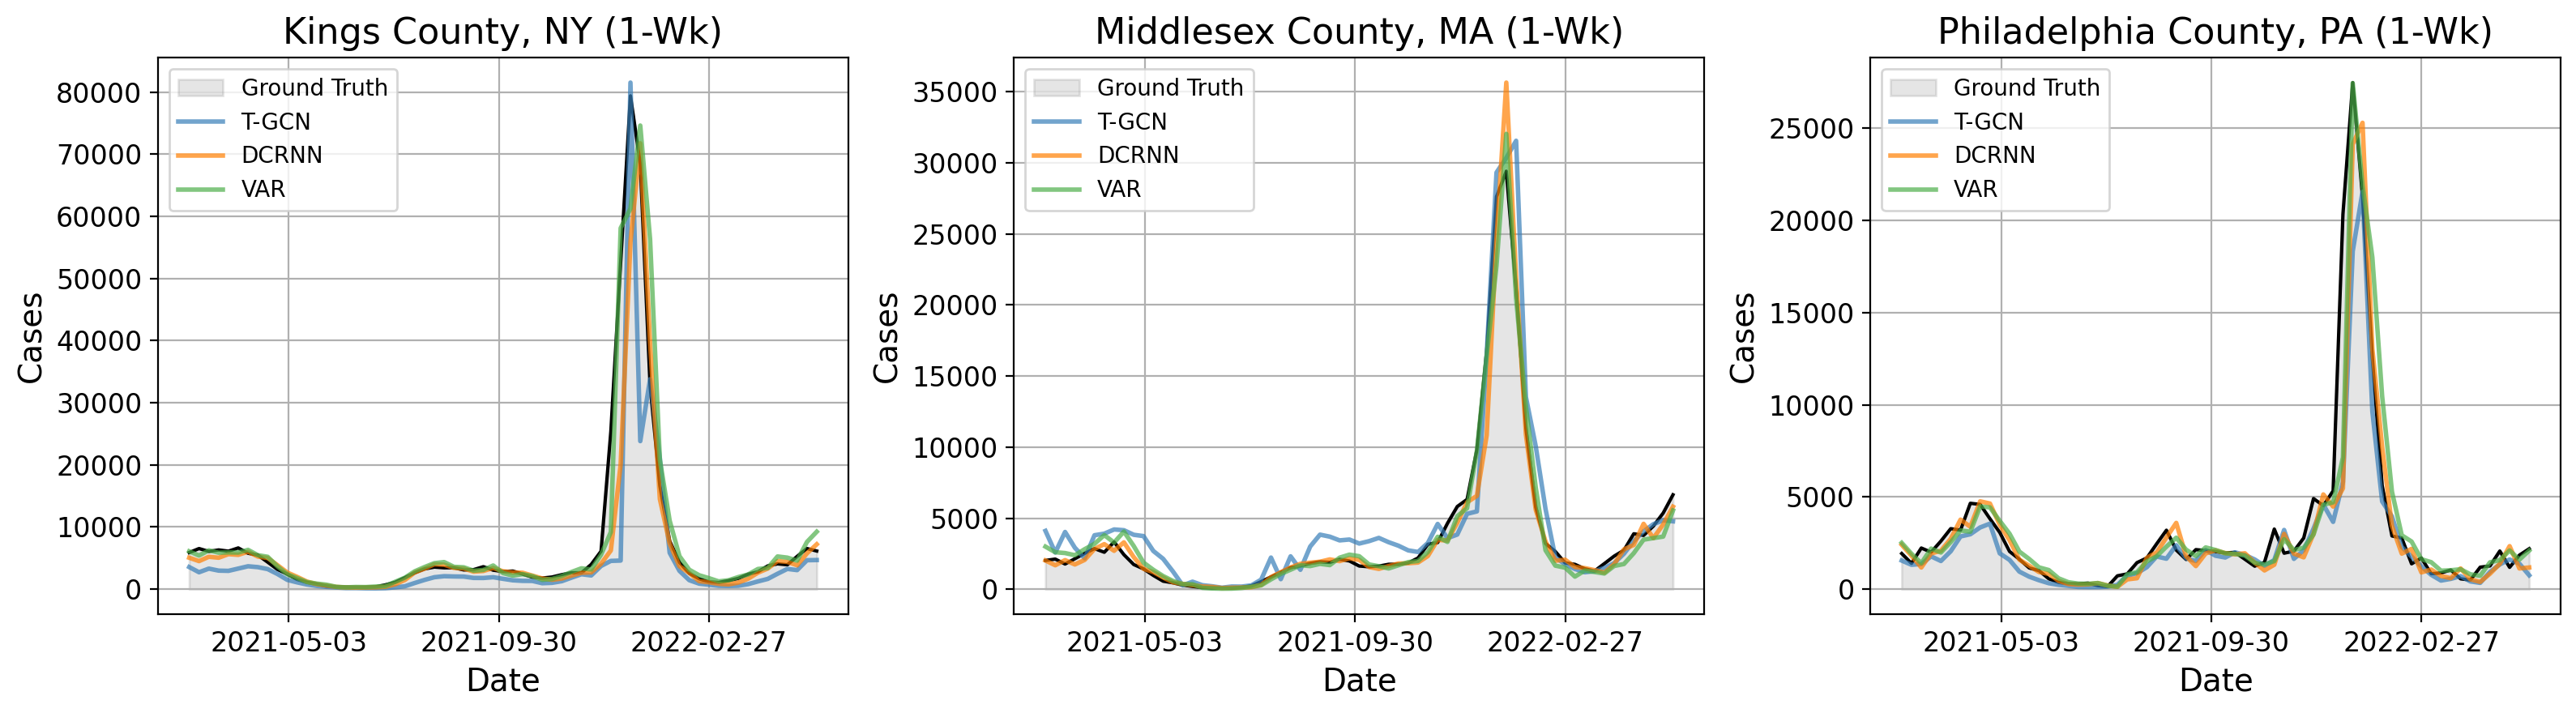

In [7]:
# what are the 2 biggest counties in the Northeastern United States?
big_locations = locations.sort_values(by="population", ascending=False)\
.groupby("state_code").first().reset_index().sort_values(by="population", ascending=False)\
.iloc[:3].reset_index()

# let's plot the predicted case counts vs. truth for best of each model
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(16, 4.5))

# iterate through our two counties of interest
for loc_idx in range(3):
    
    # unpack our locations
    location_key, county_name, state_code = big_locations.loc[loc_idx]\
    [["location_key", "county_name", "state_code"]]
    
    # immediately label + grid up
    ax[loc_idx].set_title(f"{county_name}, {state_code} (1-Wk)", fontsize=16)
    ax[loc_idx].grid()
    ax[loc_idx].set_xlabel("Date", fontsize=14)
    ax[loc_idx].set_ylabel("Cases", fontsize=14)
    ax[loc_idx].tick_params(labelsize=12)
    
    # plot the true case counts
    ax[loc_idx].plot(cases.loc[pred_start_shared : ][location_key], color="black")
    ax[loc_idx].fill_between(cases.loc[pred_start_shared : ][location_key].index,
                             cases.loc[pred_start_shared : ][location_key].values,
                             color="grey", alpha=0.2, label="Ground Truth")
    
    # plot the best T-GCN
    best_tgcn = logs.query("model == 'tgcn' and fh == 1").sort_values(by=f"sMAE_{location_key}").iloc[0]
    fh, log_trans, num_nodes, cluster_mech, num_lags, shuffle = best_tgcn[["fh", "log_trans", 
                                                                           "num_nodes", "cluster_mech", 
                                                                           "num_lags", "shuffle"]]
    fname = f"fh={fh}_log-trans={log_trans}_num-nodes={int(num_nodes)}_cluster-mech={cluster_mech}_num-lags={num_lags}_shuffle={shuffle}.csv"
    preds = pd.read_csv(f"results/tgcn/{fname}")
    preds.date = pd.to_datetime(preds.date)
    preds.set_index("date", inplace=True)
    ax[loc_idx].plot(preds[location_key].loc[pred_start_shared : ], 
                     linewidth=2, color=colors[0], label="T-GCN", alpha=0.7)
    
    # plot the best DCRNN
    best_dcrnn = logs.query("model == 'dcrnn' and fh == 1").sort_values(by=f"sMAE_{location_key}").iloc[0]
    fh, log_trans, num_nodes, cluster_mech, num_lags, shuffle = best_dcrnn[["fh", "log_trans", 
                                                                            "num_nodes", "cluster_mech", 
                                                                            "num_lags", "shuffle"]]
    fname = f"fh={fh}_log-trans={log_trans}_num-nodes={int(num_nodes)}_cluster-mech={cluster_mech}_num-lags={num_lags}_shuffle={shuffle}.csv"
    preds = pd.read_csv(f"results/dcrnn/{fname}")
    preds.date = pd.to_datetime(preds.date)
    preds.set_index("date", inplace=True)
    ax[loc_idx].plot(preds[location_key].loc[pred_start_shared : ], 
                     linewidth=2, color=colors[1], label="DCRNN", alpha=0.7)
    
    # plot the best VAR
    best_var = logs.query("model == 'linear' and fh == 1").sort_values(by=f"sMAE_{location_key}").iloc[0]
    fh, log_trans, cluster_mech, num_lags, local_reg, neighbor_reg = best_var[["fh", "log_trans", 
                                                                               "cluster_mech", 
                                                                               "num_lags", "local_reg", 
                                                                               "neighbor_reg"]]
    fname = f"fh={fh}_log-trans={log_trans}_num-lags={num_lags}_cluster-mech={cluster_mech}_reg-scheme={int(local_reg)}+{int(neighbor_reg)}.csv"
    preds = pd.read_csv(f"results/linear/{fname}")
    preds.date = pd.to_datetime(preds.date)
    preds.set_index("date", inplace=True)
    ax[loc_idx].plot(preds[location_key].loc[pred_start_shared : ], 
                     linewidth=2, color=colors[2], label="VAR", alpha=0.7)
    
    '''
    # plot the naive as a finisher
    naive_values = cases.loc[pred_start_shared - relativedelta(days=7) : 
                         pred_end - relativedelta(days=7)][location_key].values
    naive_preds = pd.Series(data=naive_values, index=preds[location_key].loc[pred_start_shared : ].index)
    ax[loc_idx].plot(naive_preds, color="red", linestyle="--")
    '''
    
    # beautify at the very end
    ax[loc_idx].legend()
    ax[loc_idx].xaxis.set_major_locator(ticker.MaxNLocator(4))

# beautify + save
plt.tight_layout()
plt.savefig("figures/rq6_example-preds.png", facecolor="white", bbox_inches="tight")
plt.show()